<a href="https://colab.research.google.com/github/singhbhupender1/DataSciencePortfolio/blob/master/SF_crime_analysis_using_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Overview
In this notebook, I will use Spark SQL for big data analysis on SF crime data.

##Datasets
I use [Police Department Incident Reports](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry/). This dataset covers crime incidents from year 2003 to year 2018. It has 2.21M rows and 13 columns. Each row is each incident. Schema includes IncidntNum, Category, Descript, DayOfWeek, Date, Time, PdDistrict, Resolution, Address, X, Y, Location, PdId]


##Questions
1. Find out all crime category in the report
2. Get case count for each category
3. Get case count for each date of the week / hour
4. Get case count for each District
5. Get case count by District on Sunday
6. Get case count in Downtown on Sunday
7. Get reasonable clusters of crime locations in SF (use K-means)


##Contents
1. Load Data
2. Use RDD to query data
3. Use Spark DataFrame to query data
4. Use Spark SQL to query data
5. Perform Spark K-means

In [0]:
# a = [] #do not execute it!!!!!!..will crash your system
# while(1):
#     a.append('1')
# #get more ram

since we are running this on goggle colab we need to install jdk 8 and spark 
Pyspark is used to automatically find spark installation


In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark
!ls

--2020-03-09 20:24:17--  https://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
Resolving archive.apache.org (archive.apache.org)... 163.172.17.199
Connecting to archive.apache.org (archive.apache.org)|163.172.17.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225883783 (215M) [application/x-gzip]
Saving to: ‘spark-2.3.1-bin-hadoop2.7.tgz’

spark-2.3.1-bin-had 100%[===================>] 215.42M  20.3MB/s    in 11s     

2020-03-09 20:24:29 (19.1 MB/s) - ‘spark-2.3.1-bin-hadoop2.7.tgz’ saved [225883783/225883783]

drive
Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv
sample_data
spark-2.3.1-bin-hadoop2.7
spark-2.3.1-bin-hadoop2.7.tgz


In [4]:
# !java -version

openjdk version "1.8.0_242"
OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08)
OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)


In [3]:
# ! update-alternatives --config java

There are 2 choices for the alternative java (providing /usr/bin/java).

  Selection    Path                                            Priority   Status
------------------------------------------------------------
* 0            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      auto mode
  1            /usr/lib/jvm/java-11-openjdk-amd64/bin/java      1111      manual mode
  2            /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java   1081      manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"


In [0]:
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SQLContext
from csv import reader
import pandas as pd

conf = SparkConf().setMaster("local[*]").setAppName('pyspark')
sc = SparkContext(conf=conf)

###1. read data

In [0]:
# data path
# url = 'https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry/'
file_path = '/content/Police_Department_Incident_Reports__Historical_2003_to_May_2018.csv'

In [0]:
#read data from the data storage
crime_data_lines = sc.textFile(file_path)
# prepare data - strip "
crimes_clean = crime_data_lines.map(lambda line: [x.strip('"') for x in next(reader([line]))])

# get header (column names)
header = crimes_clean.first()




In [11]:
# remove the first line of data
rdd_crimes = crimes_clean.filter(lambda x: x != header)
#get the total number of data
print(rdd_crimes.count())

2215024


###2. RDD Query

In [12]:
# inspection
print(header)

['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', ':@computed_region_yftq_j783', ':@computed_region_p5aj_wyqh', ':@computed_region_rxqg_mtj9', ':@computed_region_bh8s_q3mv', ':@computed_region_fyvs_ahh9', ':@computed_region_9dfj_4gjx', ':@computed_region_n4xg_c4py', ':@computed_region_4isq_27mq', ':@computed_region_fcz8_est8', ':@computed_region_pigm_ib2e', ':@computed_region_9jxd_iqea', ':@computed_region_6pnf_4xz7', ':@computed_region_6ezc_tdp2', ':@computed_region_h4ep_8xdi', ':@computed_region_nqbw_i6c3', ':@computed_region_2dwj_jsy4']


In [13]:
# inspection
rdd_crimes.take(1)

[['110308742',
  'MISSING PERSON',
  'FOUND PERSON',
  'Friday',
  '04/15/2011',
  '16:00',
  'TARAVAL',
  'LOCATED',
  '0 Block of CRESPI DR',
  '-122.476327815126',
  '37.7196874952717',
  'POINT (-122.476327815126 37.7196874952717)',
  '11030874275000',
  '42',
  '10',
  '8',
  '16',
  '1',
  '8',
  '4',
  '64',
  '14',
  '',
  '',
  '',
  '',
  '',
  '',
  '2',
  '',
  '',
  '',
  '']]

In [14]:
# get number of partitions
print('num partitions:', rdd_crimes.getNumPartitions())

num partitions: 17


In [15]:
# get all distinct Crime Category
rdd_crimes.map(lambda x: x[1]).distinct().collect()

['WEAPON LAWS',
 'DRUG/NARCOTIC',
 'FRAUD',
 'SUICIDE',
 'FAMILY OFFENSES',
 'SECONDARY CODES',
 'LARCENY/THEFT',
 'NON-CRIMINAL',
 'ROBBERY',
 'BAD CHECKS',
 'SUSPICIOUS OCC',
 'SEX OFFENSES, NON FORCIBLE',
 'EMBEZZLEMENT',
 'MISSING PERSON',
 'SEX OFFENSES, FORCIBLE',
 'OTHER OFFENSES',
 'FORGERY/COUNTERFEITING',
 'BRIBERY',
 'PROSTITUTION',
 'LIQUOR LAWS',
 'PORNOGRAPHY/OBSCENE MAT',
 'TREA',
 'VEHICLE THEFT',
 'RECOVERED VEHICLE',
 'TRESPASS',
 'LOITERING',
 'WARRANTS',
 'BURGLARY',
 'EXTORTION',
 'DRUNKENNESS',
 'STOLEN PROPERTY',
 'ASSAULT',
 'RUNAWAY',
 'DRIVING UNDER THE INFLUENCE',
 'VANDALISM',
 'KIDNAPPING',
 'DISORDERLY CONDUCT',
 'ARSON',
 'GAMBLING']

In [16]:
# get case count
rdd_crimes.map(lambda x: x[1]).countByValue()

defaultdict(int,
            {'ARSON': 3931,
             'ASSAULT': 194694,
             'BAD CHECKS': 925,
             'BRIBERY': 813,
             'BURGLARY': 91543,
             'DISORDERLY CONDUCT': 10040,
             'DRIVING UNDER THE INFLUENCE': 5672,
             'DRUG/NARCOTIC': 119628,
             'DRUNKENNESS': 9826,
             'EMBEZZLEMENT': 2988,
             'EXTORTION': 741,
             'FAMILY OFFENSES': 1183,
             'FORGERY/COUNTERFEITING': 23050,
             'FRAUD': 41542,
             'GAMBLING': 348,
             'KIDNAPPING': 5346,
             'LARCENY/THEFT': 480448,
             'LIQUOR LAWS': 4083,
             'LOITERING': 2430,
             'MISSING PERSON': 64961,
             'NON-CRIMINAL': 238323,
             'OTHER OFFENSES': 309358,
             'PORNOGRAPHY/OBSCENE MAT': 59,
             'PROSTITUTION': 16701,
             'RECOVERED VEHICLE': 8716,
             'ROBBERY': 55867,
             'RUNAWAY': 4440,
             'SECONDARY C

In [17]:
# get case count by date
rdd_crimes.map(lambda x: x[3]).countByValue()

defaultdict(int,
            {'Friday': 337941,
             'Monday': 306587,
             'Saturday': 320593,
             'Sunday': 294592,
             'Thursday': 316156,
             'Tuesday': 315135,
             'Wednesday': 324020})

In [18]:
# get case count by hour
rdd_crimes.map(lambda x: pd.Timestamp(x[5]).hour).countByValue()

defaultdict(int,
            {0: 113096,
             1: 65182,
             2: 54550,
             3: 35596,
             4: 25285,
             5: 22413,
             6: 33494,
             7: 55551,
             8: 82459,
             9: 89303,
             10: 95469,
             11: 97620,
             12: 132631,
             13: 108540,
             14: 112078,
             15: 120190,
             16: 125548,
             17: 135481,
             18: 140918,
             19: 126404,
             20: 115010,
             21: 109559,
             22: 113915,
             23: 104732})

In [19]:
# get start date
print('data begins at', rdd_crimes.map(lambda x: pd.Timestamp(x[4])).min())
# get end date
print('data ends at', rdd_crimes.map(lambda x: pd.Timestamp(x[4])).max())

data begins at 2003-01-01 00:00:00
data ends at 2018-05-15 00:00:00


In [20]:
# get case count by district
rdd_crimes.map(lambda x: x[6]).countByValue()

defaultdict(int,
            {'': 1,
             'BAYVIEW': 221000,
             'CENTRAL': 226255,
             'INGLESIDE': 194180,
             'MISSION': 300076,
             'NORTHERN': 272713,
             'PARK': 125479,
             'RICHMOND': 116818,
             'SOUTHERN': 399785,
             'TARAVAL': 166971,
             'TENDERLOIN': 191746})

In [21]:
# get case count by district on Sunday
rdd_crimes.filter(lambda x: x[3] == 'Sunday').map(lambda x: x[6]).countByValue()

defaultdict(int,
            {'': 1,
             'BAYVIEW': 29104,
             'CENTRAL': 32096,
             'INGLESIDE': 25146,
             'MISSION': 40093,
             'NORTHERN': 37327,
             'PARK': 16776,
             'RICHMOND': 15750,
             'SOUTHERN': 52647,
             'TARAVAL': 21308,
             'TENDERLOIN': 24344})

###3. DataFrame Query

In [0]:
# dataframe / SQL entry point
from pyspark.sql import SparkSession
# spark schema utils
from pyspark.sql.types import *

# spark structure data (dataframe / SQL) entry point
sql_sc = SQLContext(sc)
spark = SparkSession(sc)

####1). manually create dataframe using rdd, and self-defined schema

In [23]:
# manual define schema
schema = StructType([
    StructField('IncidntNum', IntegerType(), True),
    StructField('Category', StringType(), True),
    StructField('Descript', StringType(), True),
    StructField('DayOfWeek', StringType(), True),
    StructField('Date', StringType(), True),
    StructField('Time', StringType(), True),
    StructField('PdDistrict', StringType(), True),
    StructField('Resolution', StringType(), True),
    StructField('Address', StringType(), True),
    StructField('X', FloatType(), True),
    StructField('Y', FloatType(), True),
    StructField('Location', StringType(), True),
    StructField('PdId', LongType(), True),
])
# convert rdd to proper type
rdd_crimes_type_converted = rdd_crimes.map(
    lambda x:
    [
       int(x[0]),
       x[1],
       x[2],
       x[3],
       x[4],
       x[5],
       x[6],
       x[7],
       x[8],
       float(x[9]),
       float(x[10]),
       x[11],
       int(x[12]),
   ]).cache()
# create data from rdd and schema
df_crimes = sql_sc.createDataFrame(rdd_crimes_type_converted, schema)
df_crimes.show(1)

+----------+--------------+------------+---------+----------+-----+----------+----------+--------------------+-----------+--------+--------------------+--------------+
|IncidntNum|      Category|    Descript|DayOfWeek|      Date| Time|PdDistrict|Resolution|             Address|          X|       Y|            Location|          PdId|
+----------+--------------+------------+---------+----------+-----+----------+----------+--------------------+-----------+--------+--------------------+--------------+
| 110308742|MISSING PERSON|FOUND PERSON|   Friday|04/15/2011|16:00|   TARAVAL|   LOCATED|0 Block of CRESPI DR|-122.476326|37.71969|POINT (-122.47632...|11030874275000|
+----------+--------------+------------+---------+----------+-----+----------+----------+--------------------+-----------+--------+--------------------+--------------+
only showing top 1 row



####2). create dataframe using rdd and list of column names

In [24]:
# create DataFrame from rdd and column name (type inference)
df_crimes1 = sql_sc.createDataFrame(rdd_crimes_type_converted, header)
df_crimes1.show(1)

IndexError: ignored

####3). create dataframe using sparking session reading file directly

In [0]:
df_crimes = spark.read.csv(file_path, header=True, inferSchema=True, ignoreTrailingWhiteSpace=True)

In [26]:
df_crimes.show(1)


+----------+--------------+------------+---------+----------+-----+----------+----------+--------------------+-----------------+----------------+--------------------+--------------+---------------------+------------------------+----------------------------+----------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|IncidntNum|      Category|    Descript|DayOfWeek|      Date| Time|PdDistrict|Resolution|             Address|                X|               Y|            Location|          PdId|SF Find Neighborhoods|Current Police Districts|Current Supervisor Districts|Analysis Neigh

In [27]:
# inspection
print('columns:', df_crimes.columns)
print()
print('counts:', df_crimes.count())
print()
print('column types:', df_crimes.dtypes)
print()
print('schema:')
print(df_crimes.printSchema())
print()
print('num partitions:', df_crimes.rdd.getNumPartitions())

columns: ['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId', 'SF Find Neighborhoods', 'Current Police Districts', 'Current Supervisor Districts', 'Analysis Neighborhoods', ':@computed_region_yftq_j783', ':@computed_region_p5aj_wyqh', ':@computed_region_rxqg_mtj9', ':@computed_region_bh8s_q3mv', ':@computed_region_fyvs_ahh9', ':@computed_region_9dfj_4gjx', ':@computed_region_n4xg_c4py', ':@computed_region_4isq_27mq', ':@computed_region_fcz8_est8', ':@computed_region_pigm_ib2e', ':@computed_region_9jxd_iqea', ':@computed_region_6pnf_4xz7', ':@computed_region_6ezc_tdp2', ':@computed_region_h4ep_8xdi', ':@computed_region_nqbw_i6c3', ':@computed_region_2dwj_jsy4']

counts: 2215024

column types: [('IncidntNum', 'int'), ('Category', 'string'), ('Descript', 'string'), ('DayOfWeek', 'string'), ('Date', 'string'), ('Time', 'string'), ('PdDistrict', 'string'), ('Resolution', 'string'), ('Address', 'string'), ('X

In [28]:
# get all distinct Crime Category
df_crimes.select('Category').distinct().show()

+--------------------+
|            Category|
+--------------------+
|               FRAUD|
|             SUICIDE|
|         LIQUOR LAWS|
|     SECONDARY CODES|
|     FAMILY OFFENSES|
|      MISSING PERSON|
|      OTHER OFFENSES|
|DRIVING UNDER THE...|
|            WARRANTS|
|               ARSON|
|FORGERY/COUNTERFE...|
|            GAMBLING|
|             BRIBERY|
|             ASSAULT|
|         DRUNKENNESS|
|           EXTORTION|
|                TREA|
|         WEAPON LAWS|
|           LOITERING|
|      SUSPICIOUS OCC|
+--------------------+
only showing top 20 rows



In [29]:
# get case count
df_crimes.groupby('Category').count().show()

+--------------------+------+
|            Category| count|
+--------------------+------+
|               FRAUD| 41542|
|             SUICIDE|  1292|
|         LIQUOR LAWS|  4083|
|     SECONDARY CODES| 25831|
|     FAMILY OFFENSES|  1183|
|      MISSING PERSON| 64961|
|      OTHER OFFENSES|309358|
|DRIVING UNDER THE...|  5672|
|            WARRANTS|101379|
|               ARSON|  3931|
|FORGERY/COUNTERFE...| 23050|
|            GAMBLING|   348|
|             BRIBERY|   813|
|             ASSAULT|194694|
|         DRUNKENNESS|  9826|
|           EXTORTION|   741|
|                TREA|    14|
|         WEAPON LAWS| 22234|
|           LOITERING|  2430|
|      SUSPICIOUS OCC| 80444|
+--------------------+------+
only showing top 20 rows



In [30]:
# get case count by date
df_crimes.groupby('DayOfWeek').count().show()

+---------+------+
|DayOfWeek| count|
+---------+------+
|Wednesday|324020|
|  Tuesday|315135|
|   Friday|337941|
| Thursday|316156|
| Saturday|320593|
|   Monday|306587|
|   Sunday|294592|
+---------+------+



In [31]:
# get case count by hour
from pyspark.sql.functions import hour

df_crimes.select(df_crimes.Time.cast('timestamp')) \
    .select(hour('Time').alias('hour')) \
    .groupby('hour') \
    .count().show()

+----+------+
|hour| count|
+----+------+
|  12|132631|
|  22|113915|
|   1| 65182|
|  13|108540|
|  16|125548|
|   6| 33494|
|   3| 35596|
|  20|115010|
|   5| 22413|
|  19|126404|
|  15|120190|
|  17|135481|
|   9| 89303|
|   4| 25285|
|   8| 82459|
|  23|104732|
|   7| 55551|
|  10| 95469|
|  21|109559|
|  11| 97620|
+----+------+
only showing top 20 rows



In [32]:
# get start date and end date
df_crimes.select(df_crimes.Date).summary('min', 'max').show()

+-------+----------+
|summary|      Date|
+-------+----------+
|    min|01/01/2003|
|    max|12/31/2017|
+-------+----------+



In [33]:
# get case count by district
df_crimes.groupby('PdDistrict').count().show()

+----------+------+
|PdDistrict| count|
+----------+------+
|   MISSION|300076|
|   BAYVIEW|221000|
|   CENTRAL|226255|
|      null|     1|
|   TARAVAL|166971|
|TENDERLOIN|191746|
| INGLESIDE|194180|
|      PARK|125479|
|  SOUTHERN|399785|
|  RICHMOND|116818|
|  NORTHERN|272713|
+----------+------+



In [34]:
# get case count by district on Sunday
df_crimes.filter(df_crimes.DayOfWeek=='Sunday').groupby('PdDistrict').count().show()

+----------+-----+
|PdDistrict|count|
+----------+-----+
|   MISSION|40093|
|   BAYVIEW|29104|
|   CENTRAL|32096|
|      null|    1|
|   TARAVAL|21308|
|TENDERLOIN|24344|
| INGLESIDE|25146|
|      PARK|16776|
|  SOUTHERN|52647|
|  RICHMOND|15750|
|  NORTHERN|37327|
+----------+-----+



In [35]:
# get case count in Downtown on Sunday
df_crimes.filter(df_crimes.DayOfWeek=='Sunday').filter(df_crimes.PdDistrict=='TENDERLOIN').count()

24344

###4. SQL Query
####1). Use SQLContext to register a Spark.DataFrame as a SQL Table
use spark SparkSession to execute SQL query

In [0]:
sql_sc.registerDataFrameAsTable(df_crimes, 'crimes')

####2). Use Spark DataFrame API to create a session-scoped Temporary view
use spark SparkSession to execute SQL query

In [0]:
df_crimes.createOrReplaceTempView("crimes")

####3). Use Spark DataFrame API to create a Global Temporary view
use spark SparkSession to execute SQL query

In [0]:
df_crimes.createGlobalTempView("crimes")

In [39]:
spark.sql("SELECT * FROM global_temp.crimes LIMIT 1").show()


+----------+--------------+------------+---------+----------+-----+----------+----------+--------------------+-----------------+----------------+--------------------+--------------+---------------------+------------------------+----------------------------+----------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+---------------------------+
|IncidntNum|      Category|    Descript|DayOfWeek|      Date| Time|PdDistrict|Resolution|             Address|                X|               Y|            Location|          PdId|SF Find Neighborhoods|Current Police Districts|Current Supervisor Districts|Analysis Neigh

In [40]:
# inspection
spark.sql("SELECT COUNT(*) AS cnt FROM global_temp.crimes").show()

+-------+
|    cnt|
+-------+
|2215024|
+-------+



In [41]:
# get all distinct Crime Category
spark.sql("SELECT DISTINCT(Category) FROM global_temp.crimes").show()

+--------------------+
|            Category|
+--------------------+
|               FRAUD|
|             SUICIDE|
|         LIQUOR LAWS|
|     SECONDARY CODES|
|     FAMILY OFFENSES|
|      MISSING PERSON|
|      OTHER OFFENSES|
|DRIVING UNDER THE...|
|            WARRANTS|
|               ARSON|
|FORGERY/COUNTERFE...|
|            GAMBLING|
|             BRIBERY|
|             ASSAULT|
|         DRUNKENNESS|
|           EXTORTION|
|                TREA|
|         WEAPON LAWS|
|           LOITERING|
|      SUSPICIOUS OCC|
+--------------------+
only showing top 20 rows



In [42]:
# get case count
spark.sql("SELECT Category, COUNT(*) AS cnt FROM global_temp.crimes GROUP BY Category").show()

+--------------------+------+
|            Category|   cnt|
+--------------------+------+
|               FRAUD| 41542|
|             SUICIDE|  1292|
|         LIQUOR LAWS|  4083|
|     SECONDARY CODES| 25831|
|     FAMILY OFFENSES|  1183|
|      MISSING PERSON| 64961|
|      OTHER OFFENSES|309358|
|DRIVING UNDER THE...|  5672|
|            WARRANTS|101379|
|               ARSON|  3931|
|FORGERY/COUNTERFE...| 23050|
|            GAMBLING|   348|
|             BRIBERY|   813|
|             ASSAULT|194694|
|         DRUNKENNESS|  9826|
|           EXTORTION|   741|
|                TREA|    14|
|         WEAPON LAWS| 22234|
|           LOITERING|  2430|
|      SUSPICIOUS OCC| 80444|
+--------------------+------+
only showing top 20 rows



In [43]:
# get case count by date
spark.sql("SELECT DayOfWeek, COUNT(*) AS cnt FROM global_temp.crimes GROUP BY DayOfWeek").show()

+---------+------+
|DayOfWeek|   cnt|
+---------+------+
|Wednesday|324020|
|  Tuesday|315135|
|   Friday|337941|
| Thursday|316156|
| Saturday|320593|
|   Monday|306587|
|   Sunday|294592|
+---------+------+



In [44]:
# get case count by hour
from pyspark.sql.functions import hour
# sub view
df_crimes.select(df_crimes.Time.cast('timestamp')) \
    .select(hour('Time').alias('hour')) \
    .createOrReplaceTempView("crimes_hour")
# query
spark.sql("SELECT hour, COUNT(*) AS cnt FROM crimes_hour GROUP BY hour").show()

+----+------+
|hour|   cnt|
+----+------+
|  12|132631|
|  22|113915|
|   1| 65182|
|  13|108540|
|  16|125548|
|   6| 33494|
|   3| 35596|
|  20|115010|
|   5| 22413|
|  19|126404|
|  15|120190|
|  17|135481|
|   9| 89303|
|   4| 25285|
|   8| 82459|
|  23|104732|
|   7| 55551|
|  10| 95469|
|  21|109559|
|  11| 97620|
+----+------+
only showing top 20 rows



In [45]:
# get start date and end date
spark.sql(
    "SELECT MIN(Date) AS start_date, MAX(Date) AS end_date "
    "FROM global_temp.crimes"
).show()

+----------+----------+
|start_date|  end_date|
+----------+----------+
|01/01/2003|12/31/2017|
+----------+----------+



In [46]:
# get case count by district
spark.sql(
    "SELECT PdDistrict, COUNT(*) AS cnt "
    "FROM global_temp.crimes "
    "GROUP BY PdDistrict"
).show()

+----------+------+
|PdDistrict|   cnt|
+----------+------+
|   MISSION|300076|
|   BAYVIEW|221000|
|   CENTRAL|226255|
|      null|     1|
|   TARAVAL|166971|
|TENDERLOIN|191746|
| INGLESIDE|194180|
|      PARK|125479|
|  SOUTHERN|399785|
|  RICHMOND|116818|
|  NORTHERN|272713|
+----------+------+



In [47]:
# get case count by district on Sunday
spark.sql(
    "SELECT PdDistrict, COUNT(*) AS cnt "
    "FROM global_temp.crimes "
    "WHERE DayOfWeek=='Sunday'"
    "GROUP BY PdDistrict"
).show()

+----------+-----+
|PdDistrict|  cnt|
+----------+-----+
|   MISSION|40093|
|   BAYVIEW|29104|
|   CENTRAL|32096|
|      null|    1|
|   TARAVAL|21308|
|TENDERLOIN|24344|
| INGLESIDE|25146|
|      PARK|16776|
|  SOUTHERN|52647|
|  RICHMOND|15750|
|  NORTHERN|37327|
+----------+-----+



In [48]:
# get case count in Downtown on Sunday
spark.sql(
    "SELECT COUNT(*) AS cnt "
    "FROM global_temp.crimes "
    "WHERE DayOfWeek='Sunday' AND PdDistrict='TENDERLOIN'"
    
).show()

+-----+
|  cnt|
+-----+
|24344|
+-----+



###5. Perform Spark K-means

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [50]:
# extract features from df_crimes
FEATURES_COL = ['X', 'Y']
df_feat = df_crimes.select(*(df_crimes[c].cast("float").alias(c) for c in FEATURES_COL))
df_feat.show(5)

+-----------+---------+
|          X|        Y|
+-----------+---------+
|-122.476326| 37.71969|
| -122.41134| 37.78127|
| -122.43519| 37.76267|
| -122.42188| 37.76492|
| -122.41393|37.751694|
+-----------+---------+
only showing top 5 rows



In [51]:
# drop null
df_feat = df_feat.na.drop()
df_feat.show(5)

+-----------+---------+
|          X|        Y|
+-----------+---------+
|-122.476326| 37.71969|
| -122.41134| 37.78127|
| -122.43519| 37.76267|
| -122.42188| 37.76492|
| -122.41393|37.751694|
+-----------+---------+
only showing top 5 rows



In [52]:
# add id to features for later join
from pyspark.sql.functions import monotonically_increasing_id 
df_feat = df_feat.select("*").withColumn("id", monotonically_increasing_id())
df_feat.show(5)

+-----------+---------+---+
|          X|        Y| id|
+-----------+---------+---+
|-122.476326| 37.71969|  0|
| -122.41134| 37.78127|  1|
| -122.43519| 37.76267|  2|
| -122.42188| 37.76492|  3|
| -122.41393|37.751694|  4|
+-----------+---------+---+
only showing top 5 rows



In [53]:
# store all features as an array of floats, and store this array as a column called "features".
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_feat = vecAssembler.transform(df_feat).select('id', 'features')
df_feat.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
|  0|[-122.47632598876...|
|  1|[-122.41133880615...|
|  2|[-122.43518829345...|
|  3|[-122.42188262939...|
|  4|[-122.41393280029...|
+---+--------------------+
only showing top 5 rows



In [0]:
# Trains a series of K-means models to pick the optimal k
import numpy as np
seed = 1
cost = np.zeros(20)
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(seed).setFeaturesCol("features")
    model = kmeans.fit(df_feat.sample(False,0.3, seed=42))
    cost[k] = model.computeCost(df_feat)

Text(0, 0.5, 'cost')

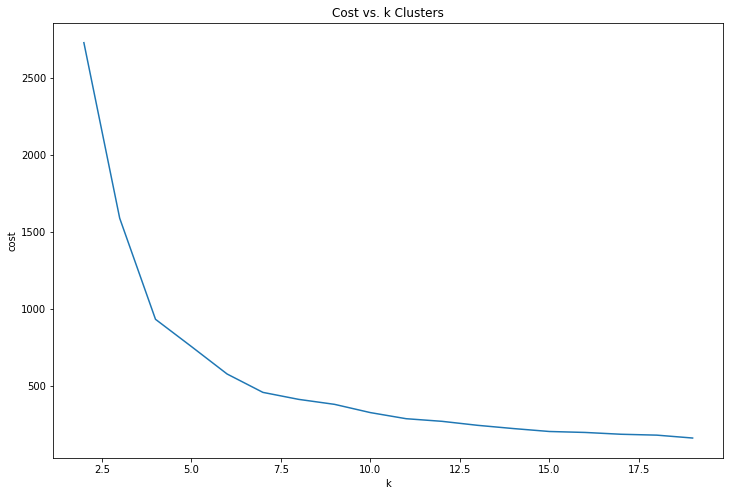

In [56]:
# plot cost vs. k clusters
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize =(12,8))
ax.plot(range(2, 20),cost[2: 20])
ax.set_title('Cost vs. k Clusters')
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [57]:
# Trains a k-means model with optimal k = 7
import time
t0 = time.time()
k = 7
seed = 1
kmeans = KMeans().setK(k).setSeed(seed).setFeaturesCol("features")
model = kmeans.fit(df_feat)
print('It took {:.2f}s to train a model'.format(time.time() - t0))

It took 36.30s to train a model


In [58]:
# get cluster centroid
centers = model.clusterCenters()
print("Cluster Centers: ")
for i, center in enumerate(centers):
    print('cluster', i, center)

Cluster Centers: 
cluster 0 [-122.41594634   37.75922811]
cluster 1 [-120.5   90. ]
cluster 2 [-122.48507615   37.76212469]
cluster 3 [-122.44034096   37.77930574]
cluster 4 [-122.39752201   37.72887324]
cluster 5 [-122.40972977   37.78598278]
cluster 6 [-122.45108715   37.72402763]


In [59]:
# get predictions
df_pred = model.transform(
    df_feat.sample(False,0.005, seed=42)
).select('id', 'prediction').cache()
df_pred.show(5)

+----+----------+
|  id|prediction|
+----+----------+
|   6|         5|
| 115|         5|
|1059|         2|
|1314|         5|
|1516|         4|
+----+----------+
only showing top 5 rows



In [0]:
# join preditions to features
pddf_pred = df_pred.join(df_feat, 'id').toPandas()

In [61]:
# get X, y
pddf_pred['X'] = pddf_pred['features'].apply(lambda x: x[0])
pddf_pred['Y'] = pddf_pred['features'].apply(lambda x: x[1])
pddf_pred.drop('features', axis=1, inplace=True)
pddf_pred.head()

,id,prediction,X,Y
0,6,5,-122.403404,37.775421
1,115,5,-122.410553,37.782501
2,1059,2,-122.476166,37.780476
3,1314,5,-122.388489,37.789574
4,1516,4,-122.390953,37.738663


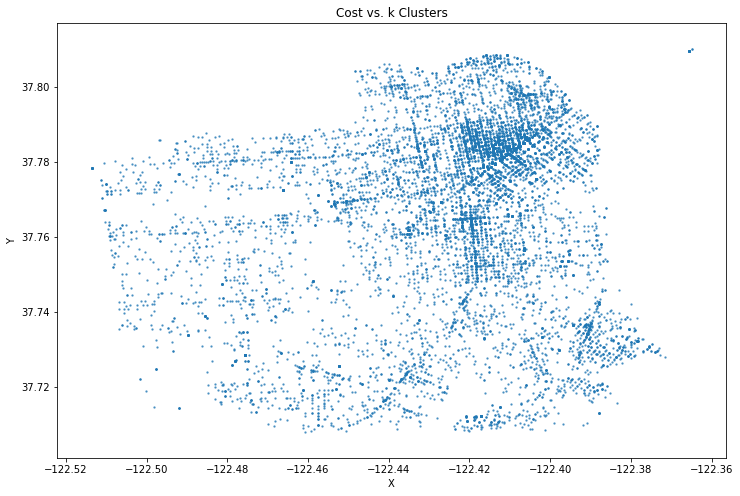

In [62]:
# plot cost vs. k clusters
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize =(12,8))
ax.scatter(pddf_pred.X, pddf_pred.Y, s=2, alpha=0.6)
ax.set_title('Cost vs. k Clusters')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

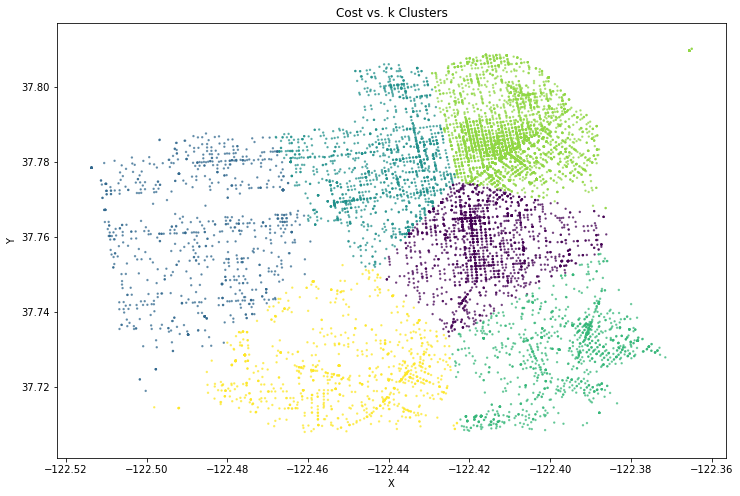

In [63]:
# plot cost vs. k clusters
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize =(12,8))
ax.scatter(pddf_pred.X, pddf_pred.Y, c=pddf_pred.prediction, s=2, alpha=0.6)
ax.set_title('Cost vs. k Clusters')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [0]:
import warnings
import statsmodels
from scipy import  stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *


In [65]:
# Get Spark dataframe
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("crime analysis").config("spark.some.config.option", "some-value").getOrCreate()
df_opt1 = spark.read.format('csv').option("header","true").load(file_path)
# Convert the datatype to date
df_opt1 = df_opt1.withColumn('Date',to_date(df_opt1.Date,format = 'MM/dd/yyyy'))
df_opt1 = df_opt1.withColumn('Time',to_timestamp(df_opt1.Time))
# Convert the datatype to int
df_opt1 = df_opt1.withColumn('X',df_opt1.X.cast('float'))
df_opt1 = df_opt1.withColumn('Y',df_opt1.Y.cast('float'))
display(df_opt1)

DataFrame[IncidntNum: string, Category: string, Descript: string, DayOfWeek: string, Date: date, Time: timestamp, PdDistrict: string, Resolution: string, Address: string, X: float, Y: float, Location: string, PdId: string, SF Find Neighborhoods: string, Current Police Districts: string, Current Supervisor Districts: string, Analysis Neighborhoods: string, :@computed_region_yftq_j783: string, :@computed_region_p5aj_wyqh: string, :@computed_region_rxqg_mtj9: string, :@computed_region_bh8s_q3mv: string, :@computed_region_fyvs_ahh9: string, :@computed_region_9dfj_4gjx: string, :@computed_region_n4xg_c4py: string, :@computed_region_4isq_27mq: string, :@computed_region_fcz8_est8: string, :@computed_region_pigm_ib2e: string, :@computed_region_9jxd_iqea: string, :@computed_region_6pnf_4xz7: string, :@computed_region_6ezc_tdp2: string, :@computed_region_h4ep_8xdi: string, :@computed_region_nqbw_i6c3: string, :@computed_region_2dwj_jsy4: string]

In [0]:
# Get Spark SQL
df_opt1.createOrReplaceTempView("sf_crime")

###Exploratary Data Analysis

In [67]:
df_opt1.describe()

DataFrame[summary: string, IncidntNum: string, Category: string, Descript: string, DayOfWeek: string, PdDistrict: string, Resolution: string, Address: string, X: string, Y: string, Location: string, PdId: string, SF Find Neighborhoods: string, Current Police Districts: string, Current Supervisor Districts: string, Analysis Neighborhoods: string, :@computed_region_yftq_j783: string, :@computed_region_p5aj_wyqh: string, :@computed_region_rxqg_mtj9: string, :@computed_region_bh8s_q3mv: string, :@computed_region_fyvs_ahh9: string, :@computed_region_9dfj_4gjx: string, :@computed_region_n4xg_c4py: string, :@computed_region_4isq_27mq: string, :@computed_region_fcz8_est8: string, :@computed_region_pigm_ib2e: string, :@computed_region_9jxd_iqea: string, :@computed_region_6pnf_4xz7: string, :@computed_region_6ezc_tdp2: string, :@computed_region_h4ep_8xdi: string, :@computed_region_nqbw_i6c3: string, :@computed_region_2dwj_jsy4: string]

In [68]:
crime_category = df_opt1.groupBy('category').count().orderBy('count', ascending=False)


DataFrame[category: string, count: bigint]

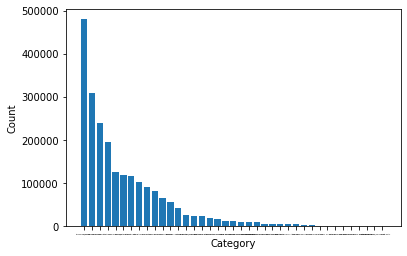

None

<Figure size 432x288 with 0 Axes>

In [69]:
# convert to pandas and visualize the results
crime_category_pd =  crime_category.toPandas()

plt.bar(np.arange(len(crime_category_pd['category'])),crime_category_pd['count'])
plt.xticks(np.arange(len(crime_category_pd['category'])),crime_category_pd['category'],fontsize = 2)
plt.xlabel('Category')
plt.ylabel('Count')
p = plt.show()

display(p)
plt.clf()

Therefore, we can find that LARCENY/THEFT has the highest frequency in all crime categories.

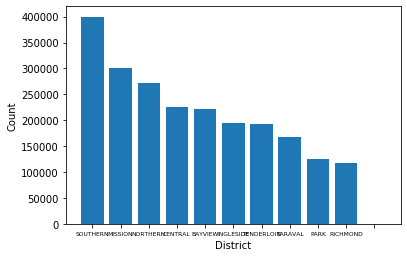

None

<Figure size 432x288 with 0 Axes>

In [74]:
# visualize based on pandas
crime_district_pddf = crime_district_df.toPandas()

# draw plt
plt.bar(np.arange(len(crime_district_pddf)),crime_district_pddf['count'])
plt.xticks(np.arange(len(crime_district_pddf)),crime_district_pddf.PdDistrict,fontsize = 6)
plt.xlabel('District')
plt.ylabel('Count')
p = plt.show()

display(p)
plt.clf()


Here, we can find southern, mission, northern, central has the comparatively high crime rate.

In [77]:
# Here we want to explore the number of crime in each month of 2015, 2016, 2017, 2018.

# Using Spark SQL
crime_month_sql = spark.sql("select year(date) as Year, month(date) as Month,count(*) as CrimeCount from sf_crime group by year(date), month(date) order by 1,2")
display(crime_month_sql)

DataFrame[Year: int, Month: int, CrimeCount: bigint]

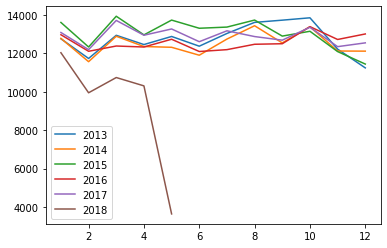

None

<Figure size 432x288 with 0 Axes>

In [78]:


# Visualize the seasonal change of crime rate
crime_month_df = crime_month_sql.toPandas()
for i in range(6):
  new_df = crime_month_df[crime_month_df['Year'] == 2013 + i]
  plt.plot(new_df['Month'],new_df['CrimeCount'],label = str(2013+i))

plt.legend()  
display(plt.show())
plt.clf()


Thus, we can find that every year the crime rate trend has the specific pattern. Especially in January, March, May and Octobor, the crime rates are comparatively higher. However, 2018's crime rate seems lower than previous years.

Thus, for SF business people, We recommend to making business planning in advance to deal with the relatively fewer travellers and higher crime rate.

###The daily fluctuation of crime rate

In [0]:
# In this case, we will pick the crime rate on 12/15 from 2013 to 2017 to see if there is any daily pattern we can explore.

crime_daily_sql = spark.sql("select Year(Date) as Year, hour(Time) as Hour, count(*) as CrimeCount from sf_crime where month(Date) = 12 and dayofmonth(date) = 15 and Year(Date)>=2013 group by Year(Date), hour(Time) order by 1,2")

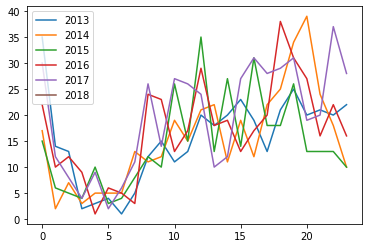

None

<Figure size 432x288 with 0 Axes>

In [80]:
# Visualize the daily change of crime rate
crime_daily_df = crime_daily_sql.toPandas()
for i in range(6):
  new_df = crime_daily_df[crime_daily_df['Year'] == 2013 + i]
  plt.plot(new_df['Hour'],new_df['CrimeCount'],label = str(2013+i))

plt.legend()  
display(plt.show())
plt.clf()

In this pattern, we can find that in the morning, crime rate is lower while as the night comes the crime rate will gradually increase. 17:00-24:00 is the most dangerous time to wander around the street in a day while in the morning people are less to go outside, which causes the crime rate becomes lower. We will recommend travellers to get up earlier to visit the city in order to avoid the incidents and enjoy safer journey.

###Time Series Prediction based on ARIMA

In [0]:
sql_district = spark.sql('select PdDistrict , count(*) from sf_crime group by PdDistrict order by 2 desc')


In [81]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)
aics = []
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
print(pdq)
 
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(seasonal_pdq)

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(pddf, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit()
            aics.append(results.aic)
            print(results.aic)
        except:
            continue

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]
[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


###Travel Recommendation in specific districts

In [84]:
sql_district.take(3)

[Row(PdDistrict='SOUTHERN', count(1)=399785),
 Row(PdDistrict='MISSION', count(1)=300076),
 Row(PdDistrict='NORTHERN', count(1)=272713)]

In [0]:
dangerous_district_category = spark.sql("select Category, count(*) as CrimeCount from sf_crime where PdDistrict = 'SOUTHERN' or PdDistrict = 'MISSION' or PdDistrict ='NORTHERN' group by Category order by 2 desc")
dangerous_district_time = spark.sql("select hour(time), count(*) as CrimeCount from sf_crime where PdDistrict = 'SOUTHERN' or PdDistrict = 'MISSION' or PdDistrict ='NORTHERN' group by hour(time) order by 2 desc")

In [86]:
# Visualize the dangerous category and dangerous time
dangerous_district_category.take(3)

[Row(Category='LARCENY/THEFT', CrimeCount=243290),
 Row(Category='OTHER OFFENSES', CrimeCount=129739),
 Row(Category='NON-CRIMINAL', CrimeCount=108217)]

In [87]:
dangerous_district_time.take(3)

[Row(hour(time)=18, CrimeCount=62045),
 Row(hour(time)=17, CrimeCount=58578),
 Row(hour(time)=19, CrimeCount=57192)]

Therefore, we recommend visitors to avoid walking or visiting the southern, mission, northern at night, particularly at 18-19. In addition, please take care the theft.


#Travel Recommendation and Police Distribution Suggestions

##Travel Recommendation:
we recommend visitors to avoid walking or visiting the southern, mission, northern at night, particularly at 18-19. In addition, please take care about the theft, of which the reslution rate is relatively low.

##Police Distribution Suggestions:
In order to improve the police efficiency, We need to deploy more police power at midnight, such as 20,21,0, when people easily encourter crime. In addition, Richmond, Central, Taraval are also some places lacking the police. Espcially for Northern,where the crime rate is high while the resolution rate is low. Also, we find that the theft, particularly vehicle theft is frequently happening, which is also needed to be paid attention.

In [93]:
# import urllib.request
# urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/sf_03_18.csv")

('/sf_03_18.csv', <http.client.HTTPMessage at 0x7f393e95deb8>)